<a href="https://colab.research.google.com/github/Adrian-Muino/DMML2022_Geneva/blob/main/Colab_Notebooks/DMML_2022_Geneva_Improved_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A. Introduction

- Blabla à écrire en intro
- Biens vers les chapitres (table des matières URL)
- NLTK SPACY à décrire

#B. Prerequisites

##Installations

In [ ]:
#Installation
!pip install sentence-transformers
!python -m spacy download fr_core_news_sm
!python -m spacy link fr_core_news_sm fr
!python -m spacy download fr_core_news_md
!pip install tensorflow_hub
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.5 MB/s 
     |████████████████████████████████| 5.8 MB 40.8 MB/s 
     |████████████████████████████████| 1.3 MB 50.5 MB/s 
     |████████████████████████████████| 182 kB 50.0 MB/s 
     |████████████████████████████████| 7.6 MB 58.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=7e4830653e64af7c9da3ed99811126d2426901d511390409f67baa2e75ac7d96
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2022-12-20 23:29:46.801019: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capabl

## Imports

In [ ]:
# Imports the functions we use all along our projects that are in python file in our GitHub
import requests
url = 'https://raw.githubusercontent.com/Adrian-Muino/DMML2022_Geneva/main/Colab_Notebooks/dmml_2022_geneva_functions.py'

r = requests.get(url)

with open('dmml_2022_geneva_functions.py', 'w') as f:
    f.write(r.text)

In [ ]:
# All the other imports
import string
import re

from dmml_2022_geneva_functions import *
import pandas as pd

import spacy
from spacy import displacy

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
nltk.download('punkt')

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier, Perceptron
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils.multiclass import unique_labels
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#C. Environment set up & exploratory data analysis

##Loading the data

In [ ]:
# load the data from our github repository
training_data = 'https://raw.githubusercontent.com/Adrian-Muino/DMML2022_Geneva/main/Data/training_data.csv'
unlabelled_data = 'https://raw.githubusercontent.com/Adrian-Muino/DMML2022_Geneva/main/Data/unlabelled_test_data.csv'

df = df_train = pd.read_csv(training_data)
df_unlabeled = df_test = pd.read_csv(unlabelled_data)

##Data tables

In [ ]:
df.head()

,id,sentence,difficulty
0,0,Les coûts kilométriques réels peuvent diverger...,C1
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,2,Le test de niveau en français est sur le site ...,A1
3,3,Est-ce que ton mari est aussi de Boston?,A1
4,4,"Dans les écoles de commerce, dans les couloirs...",B1


In [ ]:
df_unlabeled.head()

,id,sentence
0,0,Nous dûmes nous excuser des propos que nous eû...
1,1,Vous ne pouvez pas savoir le plaisir que j'ai ...
2,2,"Et, paradoxalement, boire froid n'est pas la b..."
3,3,"Ce n'est pas étonnant, car c'est une saison my..."
4,4,"Le corps de Golo lui-même, d'une essence aussi..."


In [ ]:
# How many sentences of each category
df_train['difficulty'].value_counts()

A1    813
C2    807
C1    798
B1    795
A2    795
B2    792
Name: difficulty, dtype: int64

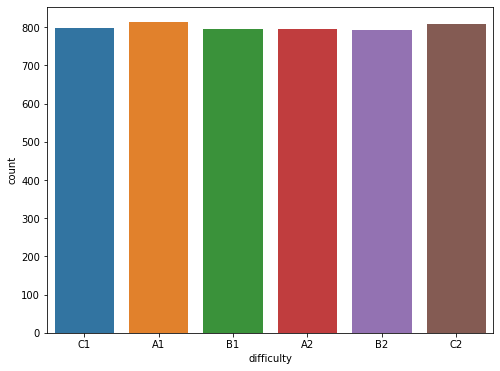

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(x=df_train.difficulty)
plt.show()

##Baseline

In [ ]:
# Base line calculation
difficulty_A1_count = df.loc[df["difficulty"] == "A1"].shape[0]
difficulty_A2_count = df.loc[df["difficulty"] == "A2"].shape[0]
difficulty_B1_count = df.loc[df["difficulty"] == "B1"].shape[0]
difficulty_B2_count = df.loc[df["difficulty"] == "B2"].shape[0]
difficulty_C1_count = df.loc[df["difficulty"] == "C1"].shape[0]
difficulty_C2_count = df.loc[df["difficulty"] == "C2"].shape[0]
baserate = max(difficulty_A1_count, difficulty_A2_count,difficulty_B1_count,difficulty_B2_count,difficulty_C1_count,difficulty_C2_count)/(df["difficulty"].shape[0])
print("Baserate = ", baserate)

Baserate =  0.169375


#D. Tokenizer & vectorizer (using two different natural language toolkits)

We decided to use TFIDF vectorizer to weight more the rare words. To our opinion, rare words can be revelevant to detect complexity.

##Spacy

In [ ]:
# Create tokenizer function
sp_sm = spacy.load('fr_core_news_sm')

print(spacy_tokenizer_sm(df.loc[2, 'sentence']))

['le', 'test', 'de', 'niveau', 'en', 'français', 'être', 'sur', 'le', 'site', 'internet', 'de', 'le', 'école', '.']


In [ ]:
tfidf_vector_spacy = TfidfVectorizer(tokenizer=spacy_tokenizer_sm)

##NLTK

In [ ]:
print(nltk_tokenizer(df.loc[2, 'sentence']))

['le', 'test', 'de', 'niveau', 'en', 'français', 'est', 'sur', 'le', 'site', 'internet', 'de', "l'école", '.']


In [ ]:
tfidf_vector_nltk = TfidfVectorizer(tokenizer=nltk_tokenizer)

# E. Classification models using the two different natural language tools (SPACY & NLTK)

In [ ]:
X = df["sentence"] # the features we want to analyze
y = df["difficulty"] # the labels we want to test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

X_train

70                                Comment t'appelles-tu ?
4347    Voilà qui serait en effet de nature à simplifi...
1122    Les pèlerins partagèrent alors cette célébrati...
4570                          Qu'est-ce que vous faites ?
34      En voici un des moins obscurs : "Plus nous dev...
                              ...                        
1033    Les micro-changements apportés par ce type d'u...
3264    J'allais à la poste quand j'ai croisé ma cousi...
1653    Au cours des années 1970 et 1980, plusieurs gr...
2607    Stop : tout d'abord, figurez-vous que les vrai...
2732    "On s'est alors dit que le terrain commençait ...
Name: sentence, Length: 3840, dtype: object

##Logistic Regression

###With Spacy

In [ ]:
# Define classifier
LR_spacy_model= LogisticRegression(solver = "lbfgs", multi_class = 'multinomial')

# Create pipeline
## The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.
LR_spacy_pipe = Pipeline([('vectorizer', tfidf_vector_spacy), ('classifier', LR_spacy_model)])

# Fit model on training set
LR_spacy_pipe.fit(X_train, y_train)

LR_spacy_pred = LR_spacy_pipe.predict(X_test)

LR_spacy_report = evaluate(y_test, LR_spacy_pred)

# Storing the model performance results in a DF called reports
reports['Logistic Regression Spacy'] = LR_spacy_report

LR_spacy_report

{'accuracy': 0.47708333333333336,
 'recall': 0.4776555731965663,
 'precision': 0.47618103606302115,
 'f1_score': 0.4747294688325296}

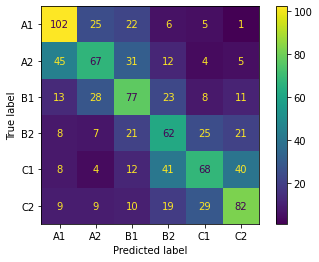

In [ ]:
plot_confusion_matrix(y_test, LR_spacy_pred, LR_spacy_pipe)

Example of type of errors

In [ ]:
badly_predicted = pd.DataFrame({'sentence':X_test[LR_spacy_pred != y_test],
              'predicted':LR_spacy_pred[LR_spacy_pred != y_test],
              'true':y_test[LR_spacy_pred != y_test]})


for i, row in badly_predicted.sample(3).iterrows():
    print(row.sentence)
    print(f"Predicted: {row.predicted}")
    print(f"Actual: {row.true}")

Les deux veuves se souvinrent avec mélancolie de leurs jeunes années.
Predicted: B2
Actual: C1
Il pleut et j'attends l'autobus
Predicted: A2
Actual: A1
Nous allons bien, nous habitons dans une petite maison ancienne avec un très beau jardin
Predicted: A1
Actual: B1


###With NLTK

NLTK == Natural Language Toolkit

In [ ]:
# Define classifier
LR_model_nltk = LogisticRegression(solver = "lbfgs", multi_class = 'multinomial')

# Create pipeline
## The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.
LR_nltk_pipe = Pipeline([('vectorizer', tfidf_vector_nltk), ('classifier', LR_model_nltk)])

# Fit model on training set
LR_nltk_pipe.fit(X_train, y_train)

LR_nltk_pred = LR_nltk_pipe.predict(X_test)

LR_nltk_report = evaluate(y_test, LR_nltk_pred)

# Storing the model performance results in a DF called reports
reports['Logistic Regression NLTK'] = LR_nltk_report

LR_nltk_report

{'accuracy': 0.4864583333333333,
 'recall': 0.48852107075520407,
 'precision': 0.48299665579640344,
 'f1_score': 0.4820740600661711}

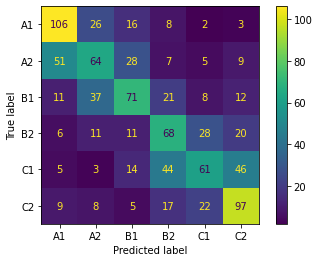

In [ ]:
plot_confusion_matrix(y_test, LR_nltk_pred, LR_nltk_pipe)

Example of type of errors

In [ ]:
badly_predicted = pd.DataFrame({'sentence':X_test[LR_nltk_pred != y_test],
              'predicted':LR_nltk_pred[LR_nltk_pred != y_test],
              'true':y_test[LR_nltk_pred != y_test]})


for i, row in badly_predicted.sample(3).iterrows():
    print(row.sentence)
    print(f"Predicted: {row.predicted}")
    print(f"Actual: {row.true}")

Le repos absolu produit le spleen.
Predicted: B2
Actual: C1
Mais trop de gens sont encore désarmés face aux ordinateurs.
Predicted: B2
Actual: C2
Il est primordial que le gouvernement poursuive ses efforts pour conforter la reprise économique dans ce pays
Predicted: A2
Actual: C2


###Summary

At this stage we can say that :
* NLTK has slightly better results than Spacy.
* However it is hard to say what causes the errors.
* An area of research would be to tune the vectorizer

##kNN

###With Spacy

In [ ]:
# Define classifier
knn_spacy_model = KNeighborsClassifier()
Nknn = list(range(1, 100))
param_grid = dict(n_neighbors=Nknn)

# Create pipeline
## The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.

knn_spacy_grid = GridSearchCV(knn_spacy_model, param_grid, cv=5, scoring='accuracy', return_train_score=False,verbose=1)

knn_spacy_pipe = Pipeline([('vectorizer',  tfidf_vector_spacy), ('classifier', knn_spacy_grid)])
# Fit model on training set
knn_spacy_pipe.fit(X_train, y_train)

best_param_knn_spacy = knn_spacy_grid .best_params_.get('n_neighbors')
print(knn_spacy_grid .best_params_)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
{'n_neighbors': 12}


In [ ]:
knn_spacy_classifier = KNeighborsClassifier(n_neighbors=best_param_knn_spacy)
# Create pipeline
## The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.
KNN_spacy_pipe = Pipeline([('vectorizer', tfidf_vector_spacy), ('classifier', knn_spacy_classifier)])

# Fit model on training set
KNN_spacy_pipe.fit(X_train, y_train)

# Predictions
KNN_spacy_pred = KNN_spacy_pipe.predict(X_test)

KNN_spacy_pred_report = evaluate(y_test, KNN_spacy_pred)

# Storing the model performance results in a DF called reports
reports['KNN Spacy'] = KNN_spacy_pred_report

KNN_spacy_pred_report

{'accuracy': 0.33958333333333335,
 'recall': 0.3390992681026839,
 'precision': 0.3878947666751313,
 'f1_score': 0.31931761937572006}

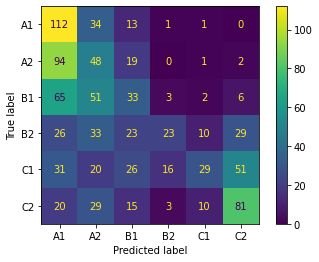

In [ ]:
plot_confusion_matrix(y_test, KNN_spacy_pred, KNN_spacy_pipe)

###With NLTK

In [ ]:
# Define classifier
knn_nltk_model = KNeighborsClassifier()
Nknn = list(range(1, 100))
param_grid = dict(n_neighbors=Nknn)

# Create pipeline
## The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.

knn_nltk_grid = GridSearchCV(knn_nltk_model, param_grid, cv=5, scoring='accuracy', return_train_score=False,verbose=1)

knn_nltk_pipe = Pipeline([('vectorizer',  tfidf_vector_nltk), ('classifier', knn_nltk_grid)])
# Fit model on training set
knn_nltk_pipe.fit(X_train, y_train)

best_param_knn_nltk = knn_nltk_grid .best_params_.get('n_neighbors')
print(knn_nltk_grid .best_params_)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
{'n_neighbors': 36}


In [ ]:
knn_nltk_classifier = KNeighborsClassifier(n_neighbors=best_param_knn_nltk)
# Create pipeline
## The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.
KNN_nltk_pipe = Pipeline([('vectorizer', tfidf_vector_nltk), ('classifier', knn_nltk_classifier)])

# Fit model on training set
KNN_nltk_pipe.fit(X_train, y_train)

# Predictions
KNN_nltk_pred = KNN_nltk_pipe.predict(X_test)

KNN_nltk_pred_report = evaluate(y_test, KNN_nltk_pred)

# Storing the model performance results in a DF called reports
reports['KNN NLTK'] = KNN_nltk_pred_report

KNN_nltk_pred_report

{'accuracy': 0.3572916666666667,
 'recall': 0.35709204798993505,
 'precision': 0.3793709754833736,
 'f1_score': 0.3255541547284067}

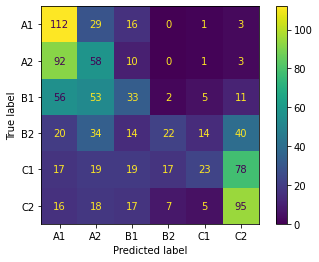

In [ ]:
plot_confusion_matrix(y_test, KNN_nltk_pred, KNN_nltk_pipe)

##Decision Tree

####With Spacy

In [ ]:
tree_spacy_model = DecisionTreeClassifier()

tree_spacy_pipe = Pipeline([('vectorizer', tfidf_vector_spacy),
                 ('classifier', tree_spacy_model)])


tree_spacy_pipe.fit(X_train, y_train)

tree_spacy_pred = tree_spacy_pipe.predict(X_test)

tree_spacy_report = evaluate(y_test, tree_spacy_pred)

# Store model performance results
reports['Decision Tree Spacy'] = tree_spacy_report

tree_spacy_report

{'accuracy': 0.3375,
 'recall': 0.3380670021610603,
 'precision': 0.3339057532585636,
 'f1_score': 0.3348733242971547}

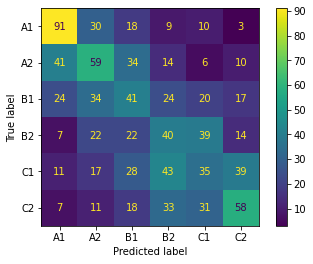

In [ ]:
plot_confusion_matrix(y_test, tree_spacy_pred, tree_spacy_pipe)

####With NLTK

In [ ]:
tree_nltk_model = DecisionTreeClassifier()

tree_nltk_pipe = Pipeline([('vectorizer', tfidf_vector_nltk),
                 ('classifier', tree_nltk_model)])


tree_nltk_pipe.fit(X_train, y_train)

tree_nltk_pred = tree_nltk_pipe.predict(X_test)

tree_nltk_report = evaluate(y_test, tree_nltk_pred)

# Store model performance results
reports['Decision Tree NLTK'] = tree_nltk_report

tree_nltk_report

{'accuracy': 0.309375,
 'recall': 0.31155151714342294,
 'precision': 0.30952225618777135,
 'f1_score': 0.3051111155798543}

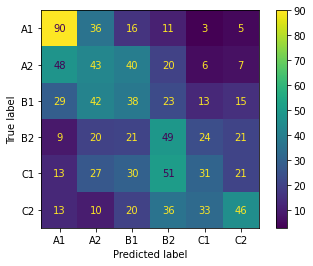

In [ ]:
plot_confusion_matrix(y_test, tree_nltk_pred, tree_nltk_pipe)

##Random Forest

####With Spacy

In [ ]:
forest_spacy_model = RandomForestClassifier()

forest_spacy_pipe = Pipeline([('vectorizer', tfidf_vector_spacy),
                 ('classifier', forest_spacy_model)])

forest_spacy_pipe.fit(X_train, y_train)

forest_spacy_pred = forest_spacy_pipe.predict(X_test)

forest_spacy_report = evaluate(y_test, forest_spacy_pred)

# Store model performance results
reports['Random Forest Spacy'] = forest_spacy_report

forest_spacy_report

{'accuracy': 0.4239583333333333,
 'recall': 0.4242856325529969,
 'precision': 0.4261514855665735,
 'f1_score': 0.41574709396613}

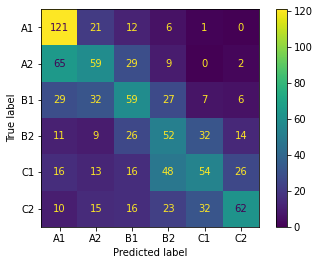

In [ ]:
plot_confusion_matrix(y_test, forest_spacy_pred, forest_spacy_pipe)

####With NLTK

In [ ]:
forest_nltk_model = RandomForestClassifier()

forest_nltk_pipe = Pipeline([('vectorizer', tfidf_vector_nltk),
                 ('classifier', forest_nltk_model)])

forest_nltk_pipe.fit(X_train, y_train)

forest_nltk_pred = forest_nltk_pipe.predict(X_test)

forest_nltk_report = evaluate(y_test, forest_nltk_pred)

# Store model performance results
reports['Random Forest NLTK'] = forest_nltk_report

forest_nltk_report

{'accuracy': 0.43020833333333336,
 'recall': 0.43220421544300375,
 'precision': 0.44252000540863135,
 'f1_score': 0.4218520483498304}

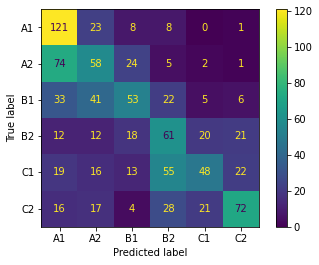

In [ ]:
plot_confusion_matrix(y_test, forest_nltk_pred, forest_nltk_pipe)

##Ridge classifier

####With Spacy

In [ ]:
ridge_spacy_model = RidgeClassifier()

ridge_spacy_pipe = Pipeline([('vectorizer', tfidf_vector_spacy),
                             ('classifier', ridge_spacy_model)])

ridge_spacy_pipe.fit(X_train, y_train)

ridge_spacy_pred = ridge_spacy_pipe.predict(X_test)

ridge_spacy_report = evaluate(y_test, ridge_spacy_pred)

# Store model performance results
reports['Ridge Classifier Spacy'] = ridge_spacy_report

ridge_spacy_report

{'accuracy': 0.46458333333333335,
 'recall': 0.4647618612515534,
 'precision': 0.4659453701846607,
 'f1_score': 0.4619179523466987}

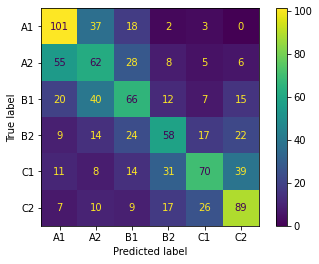

In [ ]:
plot_confusion_matrix(y_test, ridge_spacy_pred, ridge_spacy_pipe)

####With NLTK

In [ ]:
ridge_nltk_model = RidgeClassifier()

ridge_nltk_pipe = Pipeline([('vectorizer', tfidf_vector_nltk),
                             ('classifier', ridge_nltk_model)])

ridge_nltk_pipe.fit(X_train, y_train)

ridge_nltk_pred = ridge_nltk_pipe.predict(X_test)

ridge_nltk_report = evaluate(y_test, ridge_nltk_pred)

# Store model performance results
reports['Ridge Classifier NLTK'] = ridge_nltk_report

ridge_nltk_report

{'accuracy': 0.48854166666666665,
 'recall': 0.4896766905572185,
 'precision': 0.4874729561439978,
 'f1_score': 0.48364906264711555}

##Perceptron classifier

####With Spacy

In [ ]:
perceptron_spacy_model = Perceptron()

perceptron_spacy_pipe = Pipeline([('vectorizer', tfidf_vector_spacy),
                 ('classifier', perceptron_spacy_model)])


perceptron_spacy_pipe.fit(X_train, y_train)

perceptron_spacy_pred = perceptron_spacy_pipe.predict(X_test)

perceptron_spacy_report = evaluate(y_test, perceptron_spacy_pred)

# Store model performance results
reports['Perceptron Classifier Spacy'] = perceptron_spacy_report

perceptron_spacy_report


{'accuracy': 0.41041666666666665,
 'recall': 0.41035209950055634,
 'precision': 0.419992178466476,
 'f1_score': 0.4117283025225354}

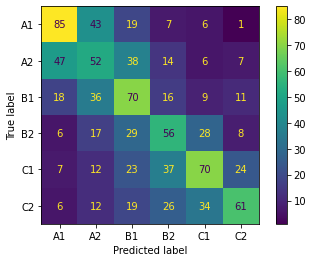

In [ ]:
plot_confusion_matrix(y_test, perceptron_spacy_pred, perceptron_spacy_pipe)

####With NLTK

In [ ]:
perceptron_nltk_model = Perceptron()

perceptron_nltk_pipe = Pipeline([('vectorizer', tfidf_vector_nltk),
                 ('classifier', perceptron_nltk_model)])


perceptron_nltk_pipe.fit(X_train, y_train)

perceptron_nltk_pred = perceptron_nltk_pipe.predict(X_test)

perceptron_nltk_report = evaluate(y_test, perceptron_nltk_pred)

# Store model performance results
reports['Perceptron Classifier NLTK'] = perceptron_nltk_report

perceptron_nltk_report


{'accuracy': 0.44583333333333336,
 'recall': 0.44498705396339355,
 'precision': 0.4463002013881355,
 'f1_score': 0.4445842616422033}

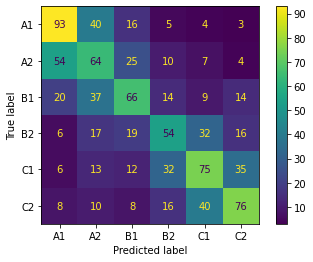

In [ ]:
plot_confusion_matrix(y_test, perceptron_nltk_pred, perceptron_nltk_pipe)

##GradientBoostingClassifier

####With Spacy

In [ ]:
gbc_spacy_model = GradientBoostingClassifier()

gbc_spacy_pipe = Pipeline([('vectorizer',  tfidf_vector_spacy),
                 ('classifier', gbc_spacy_model)])

gbc_spacy_pipe.fit(X_train, y_train)

gbc_spacy_pred = gbc_spacy_pipe.predict(X_test)

gbc_spacy_report = evaluate(y_test, gbc_spacy_pred)

# Store model performance results
reports['Gradient Boosting Classifier Spacy'] = gbc_spacy_report

gbc_spacy_report


{'accuracy': 0.415625,
 'recall': 0.4159511264512989,
 'precision': 0.41650478311654693,
 'f1_score': 0.41221728428992416}

####With NLTK

In [ ]:
gbc_nltk_model = GradientBoostingClassifier()

gbc_nltk_pipe = Pipeline([('vectorizer',  tfidf_vector_nltk),
                 ('classifier', gbc_nltk_model)])

gbc_nltk_pipe.fit(X_train, y_train)

gbc_nltk_pred = gbc_nltk_pipe.predict(X_test)

gbc_nltk_report = evaluate(y_test, gbc_nltk_pred)

# Store model performance results
reports['Gradient Boosting Classifier NLTK'] = gbc_nltk_report

gbc_nltk_report

{'accuracy': 0.421875,
 'recall': 0.42357110391724845,
 'precision': 0.4273347166673555,
 'f1_score': 0.41787358510433154}

##XGB classifier

####With Spacy

In [ ]:
from xgboost import XGBClassifier

xgb_spacy_model = XGBClassifier()
xgb_spacy_pipe = Pipeline([('vectorizer', tfidf_vector_spacy), ('classifier', xgb_spacy_model)])

xgb_spacy_pipe.fit(X_train, y_train)

xgb_spacy_pred = xgb_spacy_pipe.predict(X_test)

xgb_spacy_report = evaluate(y_test, xgb_spacy_pred)

# Store model performance results
reports['XGB Classifier Spacy'] = xgb_spacy_report

xgb_spacy_report

{'accuracy': 0.40729166666666666,
 'recall': 0.40737400249510963,
 'precision': 0.40633065314814026,
 'f1_score': 0.4004317790331446}

####With NLTK

In [ ]:
xgb_nltk_model = XGBClassifier()
xgb_nltk_pipe = Pipeline([('vectorizer', tfidf_vector_nltk), ('classifier', xgb_nltk_model)])

xgb_nltk_pipe.fit(X_train, y_train)

xgb_nltk_pred = xgb_nltk_pipe.predict(X_test)

xgb_nltk_report = evaluate(y_test, xgb_nltk_pred)

# Store model performance results
reports['XGB Classifier NLTK'] = xgb_nltk_report 

xgb_nltk_report

{'accuracy': 0.39166666666666666,
 'recall': 0.3933612614746378,
 'precision': 0.3982022538874536,
 'f1_score': 0.38183735819807363}

##SGD Classifier

####With spacy

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_spacy_model = SGDClassifier()

sgd_spacy_pipe = Pipeline([('vectorizer', tfidf_vector_spacy), ('classifier', sgd_spacy_model)])

sgd_spacy_pipe.fit(X_train, y_train)

sgd_spacy_pred = sgd_spacy_pipe.predict(X_test)

sgd_spacy_report = evaluate(y_test, sgd_spacy_pred)

# Store model performance results
reports['SGD Classifier Spacy'] = sgd_spacy_report

sgd_spacy_report


{'accuracy': 0.4552083333333333,
 'recall': 0.4557667697419589,
 'precision': 0.457317542305659,
 'f1_score': 0.45460452201895984}

####With NLTK

In [ ]:
sgd_nltk_model = SGDClassifier()

sgd_nltk_pipe = Pipeline([('vectorizer', tfidf_vector_nltk), ('classifier', sgd_nltk_model)])

sgd_nltk_pipe.fit(X_train, y_train)

sgd_nltk_pred = sgd_nltk_pipe.predict(X_test)

sgd_nltk_report = evaluate(y_test, sgd_nltk_pred)

# Store model performance results
reports['SGD Classifier NLTK'] = sgd_nltk_report

sgd_nltk_report


{'accuracy': 0.47708333333333336,
 'recall': 0.4779203905070721,
 'precision': 0.4752235436934486,
 'f1_score': 0.4727939354208484}

#F. Models Comparison

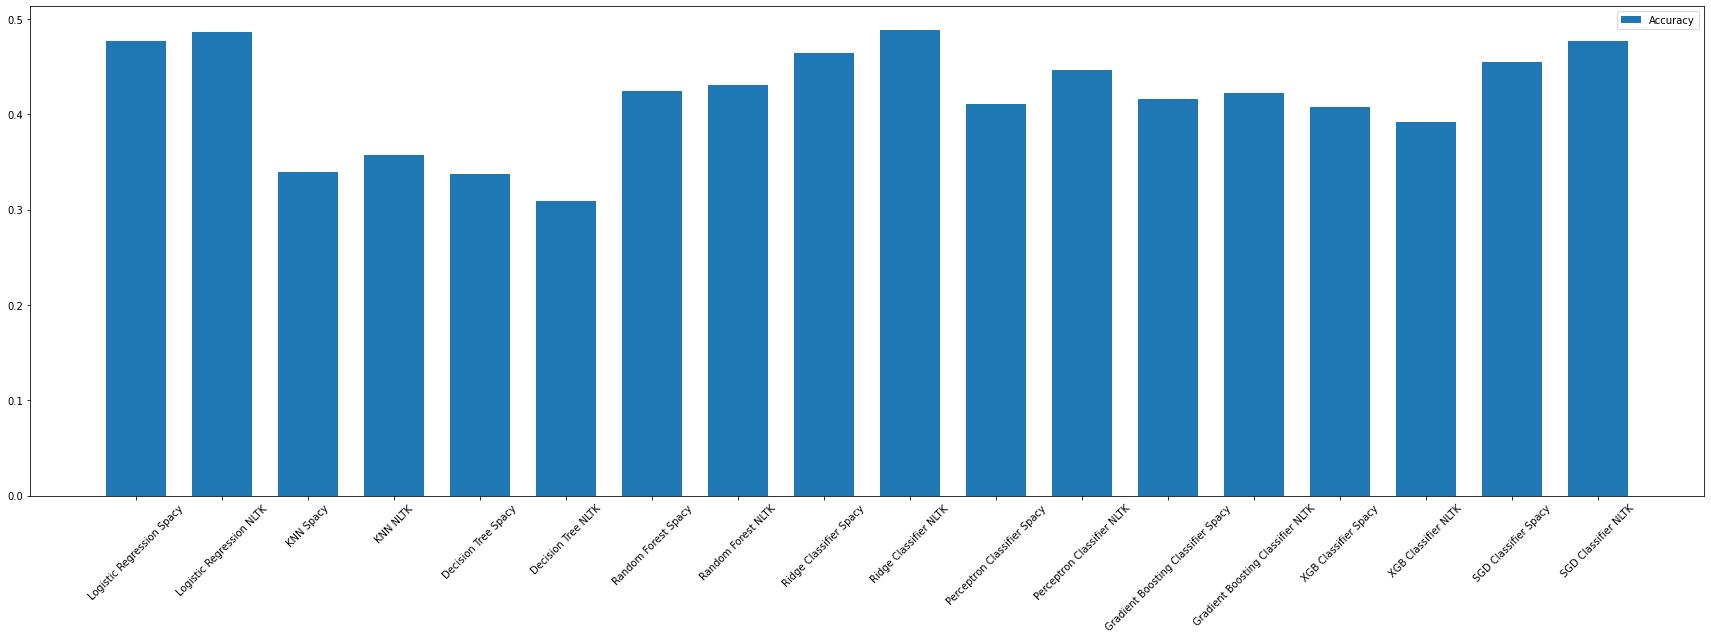

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(30,9))

width = 0.70
labels = reports.keys()
report_values_accuracy = [x['accuracy'] for x in reports.values()]

ax.bar(labels, report_values_accuracy, 
        label='Accuracy', width=width)

plt.xticks(rotation=45)
ax.legend()

In [ ]:
models_comparaison_table2 = pd.DataFrame({'Model name':pd.Series(reports.keys()),'Accuracy':pd.Series(report_values_accuracy)}).sort_values(by=['Accuracy'],ascending=False)
models_comparaison_table2.set_index(['Model name']).T

Model name,Ridge Classifier NLTK,Logistic Regression NLTK,Logistic Regression Spacy,SGD Classifier NLTK,Ridge Classifier Spacy,SGD Classifier Spacy,Perceptron Classifier NLTK,Random Forest NLTK,Random Forest Spacy,Gradient Boosting Classifier NLTK,Gradient Boosting Classifier Spacy,Perceptron Classifier Spacy,XGB Classifier Spacy,XGB Classifier NLTK,KNN NLTK,KNN Spacy,Decision Tree Spacy,Decision Tree NLTK
Accuracy,0.488542,0.486458,0.477083,0.477083,0.464583,0.455208,0.445833,0.430208,0.423958,0.421875,0.415625,0.410417,0.407292,0.391667,0.357292,0.339583,0.3375,0.309375


# G. Some outcomes

###First Submission

In [ ]:
# Used the best model in terms of accuracy
geneva_predictions_ridge_nltk = ridge_nltk_pipe.predict(df_unlabeled["sentence"])

first_submission = pd.DataFrame(geneva_predictions_ridge_nltk,columns=["difficulty"])
first_submission = first_submission.rename_axis("id")

first_submission.to_csv("Geneva_predictions_ridge_nltk.csv") 

In [ ]:
first_submission

,difficulty
id,
0,C2
1,B1
2,A1
3,A1
4,C2
...,...
1195,B1
1196,A2
1197,C2


###Second Submission

In [ ]:
# Used the best model in terms of accuracy
geneva_predictions_sgd_nltk = sgd_nltk_pipe.predict(df_unlabeled["sentence"])

second_submission = pd.DataFrame(geneva_predictions_sgd_nltk ,columns=["difficulty"])
second_submission = second_submission.rename_axis("id")

second_submission.to_csv("Geneva_predictions_sgd_nltk.csv") 

In [ ]:
second_submission

,difficulty
id,
0,C2
1,B1
2,A1
3,A1
4,C2
...,...
1195,B1
1196,A2
1197,C2


###Third Submission

In [ ]:
# Used the best model in terms of accuracy
geneva_predictions_LR_nltk = LR_nltk_pipe.predict(df_unlabeled["sentence"])

third_submission = pd.DataFrame(geneva_predictions_LR_nltk ,columns=["difficulty"])
third_submission = third_submission.rename_axis("id")

third_submission.to_csv("Geneva_predictions_LR_nltk.csv") 

In [ ]:
third_submission

,difficulty
id,
0,C2
1,A2
2,A1
3,B1
4,C2
...,...
1195,B1
1196,A2
1197,C2
